In [7]:
!pip install -q snscrape wordcloud vaderSentiment scikit-learn tensorflow==2.12.0 nltk spacy gensim streamlit --quiet
import os, json, re, string
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")
print("Working dir:", os.getcwd())

Working dir: C:\Users\Pawan


In [8]:
Path("data").mkdir(exist_ok=True)
csv_path = "data/Tweets.csv"

In [13]:
import pandas as pd

df = pd.read_csv("Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [17]:
df.columns


Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [18]:
df = df.rename(columns={
    "text": "content",
    "tweet_created": "date",
    "airline_sentiment": "label"
})


Total rows: 999
Label distribution:


negative    514
neutral     272
positive    213
Name: label, dtype: int64

,content,date
0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800
1,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800
2,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800
3,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800
4,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800


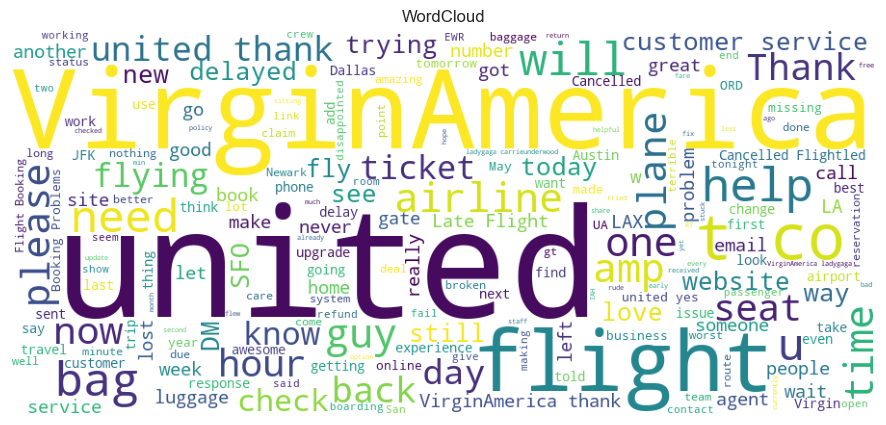

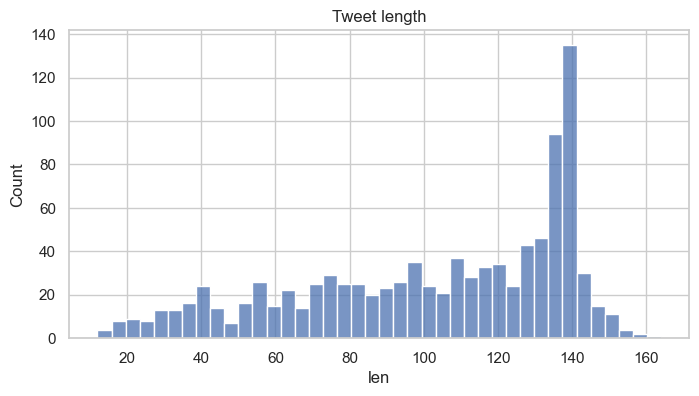

In [19]:
print("Total rows:", len(df))
if 'label' in df.columns:
    print("Label distribution:")
    display(df['label'].value_counts())

display(df[['content','date']].head())

from wordcloud import WordCloud
text = " ".join(df['content'].astype(str).tolist()[:5000])
if len(text)>0:
    wc = WordCloud(width=900,height=400, background_color='white').generate(text)
    plt.figure(figsize=(12,5)); plt.imshow(wc); plt.axis('off'); plt.title("WordCloud"); plt.show()

df['len'] = df['content'].astype(str).str.len()
plt.figure(figsize=(8,4)); sns.histplot(df['len'], bins=40); plt.title('Tweet length'); plt.show()


In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def vader_label(text):
    s = analyzer.polarity_scores(str(text))['compound']
    if s >= 0.05: return "positive"
    if s <= -0.05: return "negative"
    return "neutral"

if 'label' not in df.columns:
    df['label'] = df['content'].apply(vader_label)
    print("Applied VADER weak labels; counts:")
    display(df['label'].value_counts())
else:
    print("Dataset already has label column.")


Dataset already has label column.


In [21]:
import nltk
nltk.download('stopwords'); nltk.download('wordnet'); nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
STOP = set(stopwords.words('english'))
lem = WordNetLemmatizer()

def clean_text(text):
    text = str(text)
    text = re.sub(r'http\S+|www.\S+', '', text)   # remove urls
    text = re.sub(r'@\w+','', text)               # remove mentions
    text = re.sub(r'#','', text)                  # remove hash symbol
    text = re.sub(r'[^A-Za-z\s]', ' ', text)      # remove punctuation/numbers
    text = text.lower().strip()
    tokens = [lem.lemmatize(w) for w in text.split() if w not in STOP and len(w)>1]
    return " ".join(tokens)

df['clean'] = df['content'].astype(str).apply(clean_text)
df[['content','clean']].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pawan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pawan\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Pawan\AppData\Roaming\nltk_data...


,content,clean
0,@VirginAmerica What @dhepburn said.,said
1,@VirginAmerica plus you've added commercials t...,plus added commercial experience tacky
2,@VirginAmerica I didn't today... Must mean I n...,today must mean need take another trip
3,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,@VirginAmerica and it's a really big bad thing...,really big bad thing


In [22]:
df.columns


Index(['tweet_id', 'label', 'airline_sentiment_confidence', 'negativereason',
       'negativereason_confidence', 'airline', 'airline_sentiment_gold',
       'name', 'negativereason_gold', 'retweet_count', 'content',
       'tweet_coord', 'date', 'tweet_location', 'user_timezone', 'len',
       'clean'],
      dtype='object')

In [23]:
df = df.rename(columns={
    'airline_sentiment': 'label',
    'text': 'content',
    'tweet_created': 'date'
})


In [24]:
df_model = df[df['label'].isin(['positive','negative'])].copy()
df_model['y'] = df_model['label'].map({'positive':1,'negative':0})
print("Binary dataset size:", df_model.shape)
display(df_model['label'].value_counts())

from sklearn.model_selection import train_test_split
X = df_model['clean']
y = df_model['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print("Train:", len(X_train), "Test:", len(X_test))


Binary dataset size: (727, 18)


negative    514
positive    213
Name: label, dtype: int64

Train: 581 Test: 146


In [25]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])
pipeline.fit(X_train, y_train)
print("Baseline TF-IDF + Logistic trained")


Baseline TF-IDF + Logistic trained


              precision    recall  f1-score   support

           0       0.88      0.94      0.91       103
           1       0.83      0.70      0.76        43

    accuracy                           0.87       146
   macro avg       0.86      0.82      0.84       146
weighted avg       0.87      0.87      0.87       146

Accuracy: 0.8698630136986302
ROC-AUC: 0.9158952359449086


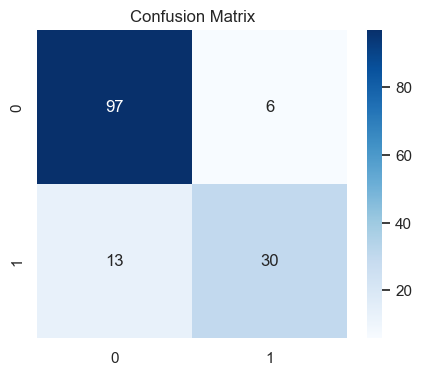

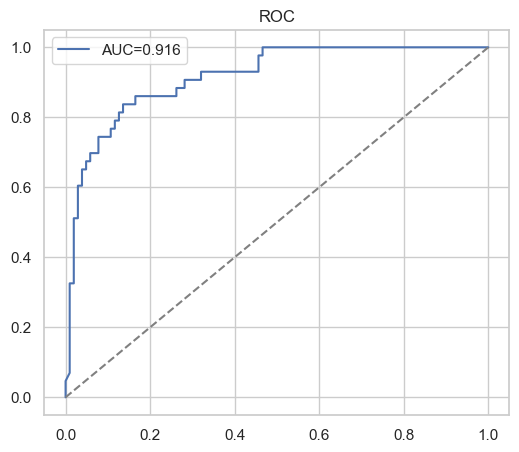

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.title("Confusion Matrix"); plt.show()

fpr,tpr,_=roc_curve(y_test,y_prob)
plt.figure(figsize=(6,5)); plt.plot(fpr,tpr,label=f"AUC={roc_auc_score(y_test,y_prob):.3f}"); plt.plot([0,1],[0,1],'--',color='gray'); plt.legend(); plt.title("ROC"); plt.show()


In [27]:
import joblib, os
os.makedirs('models', exist_ok=True)
joblib.dump(pipeline, "models/tfidf_logreg_pipeline.pkl")
print("Saved models/tfidf_logreg_pipeline.pkl")


Saved models/tfidf_logreg_pipeline.pkl


In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCAB = 20000
MAX_LEN = 120

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print("Vocab size:", min(MAX_VOCAB, len(tokenizer.word_index)+1))
print("Train shape:", X_train_pad.shape)


Vocab size: 1756
Train shape: (581, 120)


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

VOCAB = min(MAX_VOCAB, len(tokenizer.word_index)+1)
EMB_DIM = 100

model = Sequential([
    Embedding(VOCAB, EMB_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])
model.summary()

history = model.fit(X_train_pad, y_train.values, epochs=5, batch_size=64, validation_split=0.1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 100)          175600    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 264,241
Trainable params: 264,241
Non-trainable params: 0
__________________________________________________

In [30]:
y_prob = model.predict(X_test_pad).ravel()
y_pred = (y_prob>=0.5).astype(int)

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


5/5 [==============================] - 3s 58ms/step
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       103
           1       0.67      0.67      0.67        43

    accuracy                           0.81       146
   macro avg       0.77      0.77      0.77       146
weighted avg       0.81      0.81      0.81       146

ROC-AUC: 0.8602393316775796


In [31]:
model.save("models/lstm_sentiment.h5")
import json
with open("models/tokenizer.json","w") as f: f.write(tokenizer.to_json())
print("Saved models/lstm_sentiment.h5 and tokenizer.json")


Saved models/lstm_sentiment.h5 and tokenizer.json


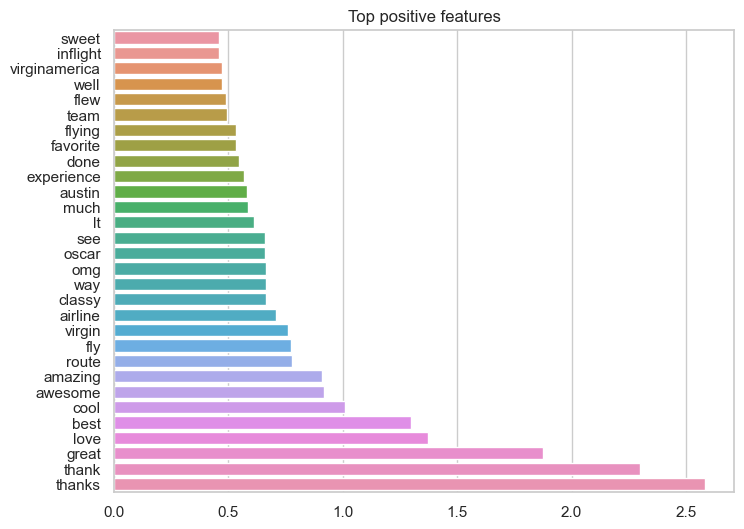

In [32]:
if 'pipeline' in globals():
    vect = pipeline.named_steps['tfidf']
    clf  = pipeline.named_steps['clf']
    import numpy as np
    topn = 30
    coefs = clf.coef_.ravel()
    idx = np.argsort(coefs)[-topn:]
    feat = np.array(vect.get_feature_names_out())[idx]
    vals = coefs[idx]
    plt.figure(figsize=(8,6)); sns.barplot(x=vals, y=feat); plt.title("Top positive features"); plt.show()


In [33]:
streamlit_code = r'''
import streamlit as st
import joblib
from pathlib import Path
import pandas as pd

st.set_page_config(layout="wide", page_title="Twitter Sentiment Dashboard")
st.title("BrandPulse — Twitter Sentiment Dashboard")

# Load model pipeline
p = Path("models") / "tfidf_logreg_pipeline.pkl"
if p.exists():
    model = joblib.load(p)
else:
    st.warning("Model pipeline not found in models/ (save pipeline first).")

# Sidebar inputs
st.sidebar.header("Input / Scrape")
query = st.sidebar.text_input("Scrape query (snscrape)","netflix lang:en")
n = st.sidebar.slider("Number of tweets to show", 50, 2000, 200)

if st.sidebar.button("Run demo (use sample dataset)"):
    # load sample
    import pandas as pd
    if Path("data/sentiment_demo.csv").exists():
        df = pd.read_csv("data/sentiment_demo.csv")
        df['pred'] = df['content'].apply(lambda x: model.predict([x])[0])
        st.dataframe(df.head(50))
    else:
        st.info("Place sample file data/sentiment_demo.csv to use demo.")

# Show distribution (if predictions exist)
if Path("data/sentiment_demo.csv").exists():
    df = pd.read_csv("data/sentiment_demo.csv")
    st.subheader("Sentiment distribution (demo)")
    st.bar_chart(df['label'].value_counts())
'''
open("app_streamlit.py","w").write(streamlit_code)
print("Wrote app_streamlit.py — run with: streamlit run app_streamlit.py")


Wrote app_streamlit.py — run with: streamlit run app_streamlit.py
